### TODO
- Date Format nicht notwendig, MESS_DATUM ist bereits numerisches Feature

In [77]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def create_lag_features(data, lag_days, variables):
    for variable in variables:
        data[f'{variable}_lag'] = data[variable].shift(-lag_days)
    return data

file_path_ort1 = 'data/Schorndorf.csv'
file_path_ort2 = 'data/Arber.csv'
file_path_ort3 = 'data/Straubing.csv'

# Laden der Daten und Filtern nach Zeitraum
df_sch = pd.read_csv(file_path_ort1, parse_dates=['DATE'])
df_sch['DATE'] = pd.to_datetime(df_sch['DATE'], format='%d.%m.%Y')
df_sch = df_sch.query('DATE >= "1996-05-01"')
df_arb = pd.read_csv(file_path_ort2, parse_dates=['DATE'])
df_arb['DATE'] = pd.to_datetime(df_arb['DATE'], format='%d.%m.%Y')
df_arb = df_arb.query('DATE >= "1996-05-01"')
df_str = pd.read_csv(file_path_ort3, parse_dates=['DATE'])
df_str['DATE'] = pd.to_datetime(df_str['DATE'], format='%d.%m.%Y')
df_str = df_str.query('DATE >= "1996-05-01"')

### TODO
- Evtl nicht anhand von heatmap löschen sondern anhand NaN/-999
- Heatmap zeigt nicht alle featurenamen, bitte noch beheben
- Bringt ein Pairplot einen Mehrwert?

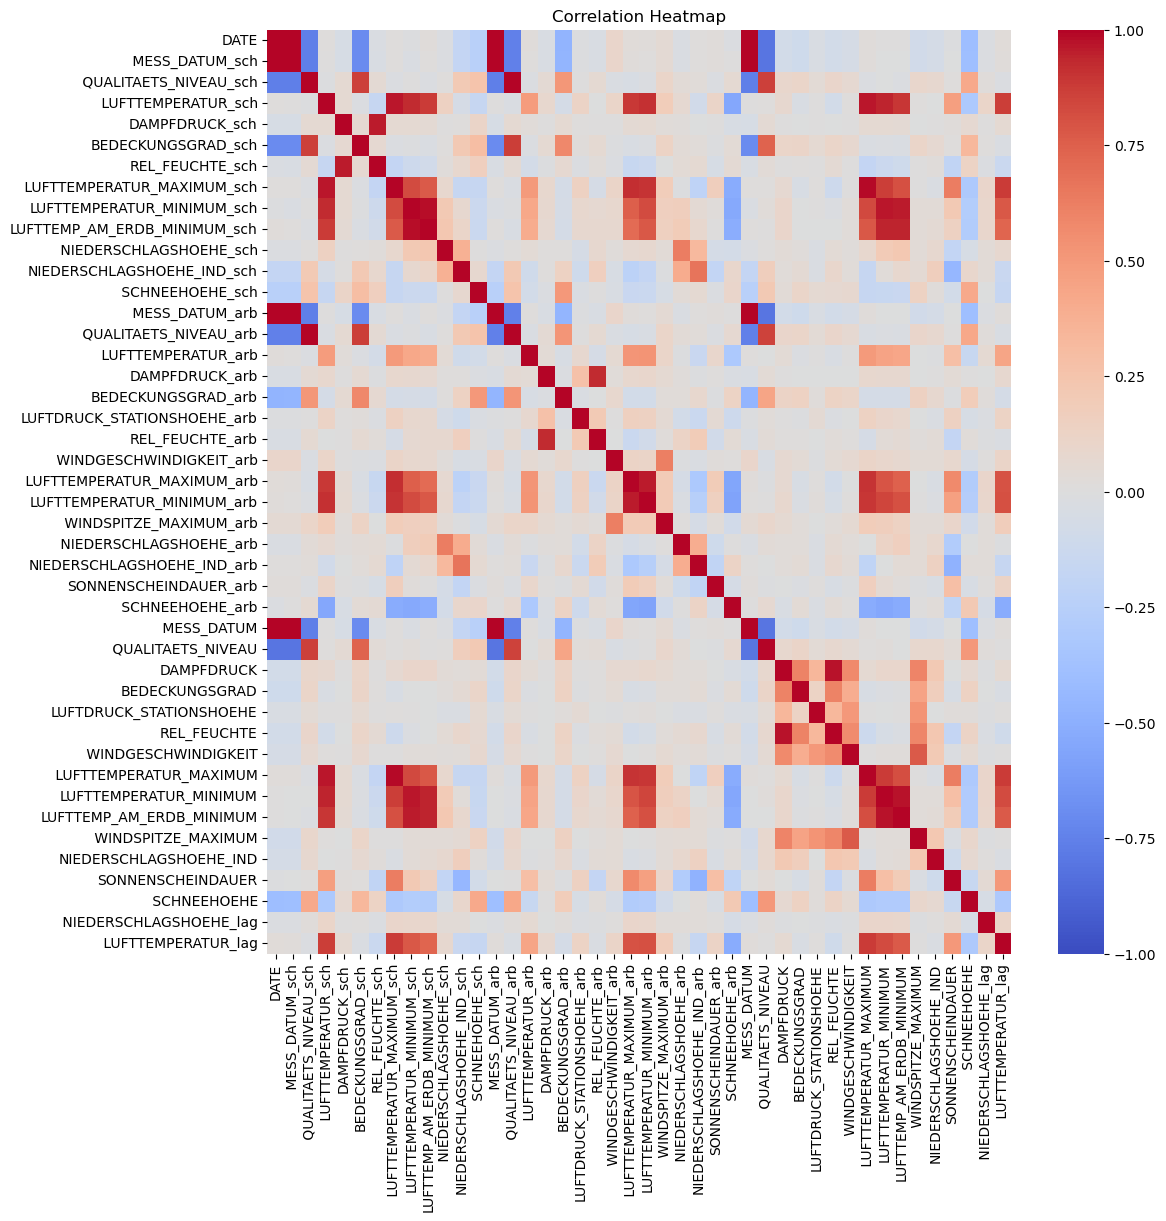

In [85]:
#Zusammenführen der DataFrames
df_combined = pd.merge(df_sch, df_arb, how='inner', on='DATE', suffixes=('_sch', '_arb'))  # Merging DFs 1 & 2 by date
df_combined = pd.merge(df_combined, df_str, how='inner', on='DATE')  # Merging 1, 2 & 3
#
df_combined_tl = create_lag_features(df_combined, lag_days=3, variables=[' NIEDERSCHLAGSHOEHE', ' LUFTTEMPERATUR'])
df_combined_tl.drop(df_combined_tl.tail(3).index, inplace=True)

#drop features witout timelag
df_combined_tl = df_combined.drop([' NIEDERSCHLAGSHOEHE', ' LUFTTEMPERATUR'], axis=1)

#print(df_combined_tl.head())

#drop features without any features (seen in heatmap)
df_combined_tl = df_combined_tl.drop(['LUFTDRUCK_STATIONSHOEHE_sch', ' WINDGESCHWINDIGKEIT_sch', 
                                    ' WINDSPITZE_MAXIMUM_sch', 'SONNENSCHEINDAUER_sch', 
                                    'LUFTTEMP_AM_ERDB_MINIMUM_arb'], axis=1)

# Plot the heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(df_combined_tl.corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

### TODO
Prüfen, ob miteinbeziehen des Qualitätsniveaus die Vorhersage verbessert
Evtl Überlegungen bezügl. weiteren Features

In [79]:
#Those Features can't tell us anything about Temperature or Precipiation
drop_features = ['DATE', ' MESS_DATUM', ' MESS_DATUM_sch', ' MESS_DATUM_arb', ' LUFTTEMPERATUR_lag',
                 ' NIEDERSCHLAGSHOEHE_lag', ' QUALITAETS_NIVEAU_sch' , ' QUALITAETS_NIVEAU_arb', 
                 ' QUALITAETS_NIVEAU']

X = df_combined_tl.drop(drop_features, axis=1)
y_temperature = df_combined_tl[' LUFTTEMPERATUR_lag']
y_precipiation = df_combined_tl[' NIEDERSCHLAGSHOEHE_lag']

### TODO
Evtl verschiedene Evaluationsmethoden ausser MSE

MSE für Temperatur: 18.4442001099948
MSE für Niederschlag: 25.84006587043836


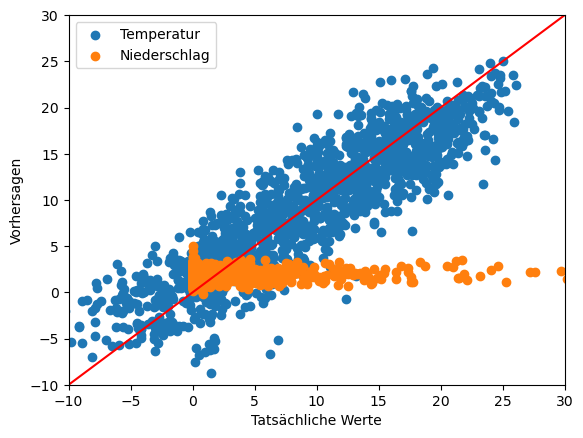

In [86]:
# Train Test Split
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y_temperature, 
y_precipiation, test_size=0.20)

# Train Model for Temperature and make predictions
model_temperature = LinearRegression()
model_temperature.fit(X_train, y1_train)
y1_prediction = model_temperature.predict(X_test)

# Train Model for Precipation and make predictions
model_precipation = LinearRegression()
model_precipation.fit(X_train, y2_train)
y2_prediction = model_precipation.predict(X_test)

# Evaluate Models based on MSE
mse_y1 = mean_squared_error(y1_test, y1_prediction)
mse_y2 = mean_squared_error(y2_test, y2_prediction)

print("MSE für Temperatur:", mse_y1)
print("MSE für Niederschlag:", mse_y2)

# Visualisiere die Vorhersagen gegen die tatsächlichen Werte
plt.scatter(y1_test, y1_prediction, label='Temperatur')
plt.scatter(y2_test, y2_prediction, label='Niederschlag')
max_value = max(max(y1_test), max(y1_prediction), max(y2_test), max(y2_prediction))
plt.plot([-10, max_value], [-10, max_value], linestyle='-', color='red')
plt.xlim(-10,30)
plt.ylim(-10,30)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhersagen')
plt.legend()
plt.show()

## Temperatur
Linearer Zusammenhang deutlich erkennbar, MSE aber noch zu hoch? Modell grundsätzlich korrekt.

## Niederschlag
Vorhersage schwankt um Wert 2 (Erwartungswert?)
Modell schlecht, da kein Linearer Zusammenhang zwischen den Features vor 3 Tagen und dem Niederschlag heute besteht. Time Lag zu groß, daher keine korelation (auch erkennbar in heatmap)